In [1]:
import os
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,recall_score,classification_report 

## 1. 加载并预处理数据

In [3]:
data = pd.read_csv("creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 展示正负样本比例

Text(0, 0.5, 'Frequency')

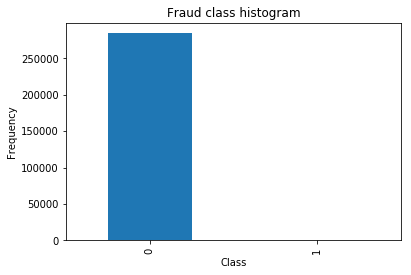

In [4]:
count_classes = pd.value_counts(data['Class'], sort=True).sort_index()
count_classes.plot(kind='bar')

plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

### 数据预处理

In [5]:
# 预处理原始特征并添加
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

# 删除无用列
data = data.drop(['Time', 'Amount'], axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


## 2. 解决样本不均衡

### 下采样策略

In [6]:
X = data.iloc[:, data.columns != 'Class']
y = data.iloc[:, data.columns == 'Class']

# 获取小样本数据
number_records_fraud = len(data[data.Class == 1])
fraud_indices = np.array(data[data.Class == 1].index)

# 获取正常样本的数据
normal_indices = data[data.Class == 0].index

# 从正常样本中随机选取数量等于小样本的样本
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace=False)
random_normal_indices = np.array(random_normal_indices)

# 将两种样本的下标组合，并取出所有完整的数据
under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])
under_sample_data = data.iloc[under_sample_indices, :]

# 获取特征和其对应的标签
X_undersample = under_sample_data.iloc[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.iloc[:, under_sample_data.columns == 'Class']

# 展示正负样本数据比例
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.Class == 0])/len(under_sample_data))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data.Class == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data:  984


## 3. 交叉验证

In [7]:
# 原始数据集切分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total number of transactions: ", len(X_train)+len(X_test))

# 下采样数据集切分
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample,
                                                                                                    y_undersample,
                                                                                                    test_size=0.3,
                                                                                                    random_state=0)

print("")
print("Number transactions train dataset: ", len(X_train_undersample))
print("Number transactions test dataset: ", len(X_test_undersample))
print("Total number of transactions: ", len(X_train_undersample)+len(X_test_undersample))

Number transactions train dataset:  199364
Number transactions test dataset:  85443
Total number of transactions:  284807

Number transactions train dataset:  688
Number transactions test dataset:  296
Total number of transactions:  984


### 4. KFold

In [8]:
def printing_Kfold_scores(x_train_data, y_train_data):
    fold = KFold(len(y_train_data), 5, shuffle=False)
    
    # 不同的正则化权重
    c_param_range = [0.01, 0.1, 1, 10, 100]
    
    results_table = pd.DataFrame(index = range(len(c_param_range),2), columns = ['C_parameter','Mean recall score'])
    results_table['C_parameter'] = c_param_range
    
    # k-fold会返回两个列表: train_indices = indices[0], test_indices = indices[1]
    j = 0
    for c_param in c_param_range:
        print('-------------------------------------------')
        print('C parameter: ', c_param)
        print('-------------------------------------------')
        print('')

        recall_accs = []
        
        for iteration, indices in enumerate(fold, start=1):
            lr = LogisticRegression(C=c_param, penalty='l1')
            lr.fit(x_train_data.iloc[indices[0], :], y_train_data.iloc[indices[0], :].values.ravel())
            
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1], :].values)
            
            recall_acc = recall_score(y_train_data.iloc[indices[1], :].values, y_pred_undersample)
            recall_accs.append(recall_acc)
            
            print('Iteration ', iteration, ': recall score = ', recall_acc)
        
        results_table.loc[j, 'Mean recall score'] = np.mean(recall_accs)
        j += 1
        print('')
        print('Mean recall score ', np.mean(recall_accs))
        print('')

    best_c = results_table.loc[results_table['Mean recall score'].astype('float64').idxmax()]['C_parameter']
    
    # 显示最佳的C
    print('*********************************************************************************')
    print('Best model to choose from cross validation is with C parameter = ', best_c)
    print('*********************************************************************************')
    
    return best_c

In [9]:
best_c = printing_Kfold_scores(X_train_undersample, y_train_undersample)

-------------------------------------------
C parameter:  0.01
-------------------------------------------

Iteration  1 : recall score =  0.958904109589041
Iteration  2 : recall score =  0.9178082191780822
Iteration  3 : recall score =  1.0
Iteration  4 : recall score =  0.9864864864864865
Iteration  5 : recall score =  0.9545454545454546

Mean recall score  0.9635488539598128

-------------------------------------------
C parameter:  0.1
-------------------------------------------

Iteration  1 : recall score =  0.8493150684931506
Iteration  2 : recall score =  0.863013698630137
Iteration  3 : recall score =  0.9152542372881356
Iteration  4 : recall score =  0.9324324324324325
Iteration  5 : recall score =  0.8939393939393939

Mean recall score  0.89079096615665

-------------------------------------------
C parameter:  1
-------------------------------------------

Iteration  1 : recall score =  0.8493150684931506
Iteration  2 : recall score =  0.9041095890410958
Iteration  3 : reca

## 5. 混肴矩阵

In [10]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric in the testing dataset:  0.9319727891156463


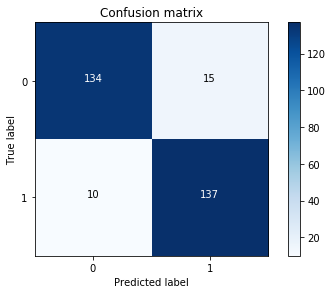

In [11]:
lr = LogisticRegression(C=best_c, penalty='l1')
lr.fit(X_train_undersample, y_train_undersample.values.ravel())
y_pred_undersample = lr.predict(X_test_undersample.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_undersample, y_pred_undersample)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=class_names,
                      title='Confusion matrix')
plt.show()

Recall metric in the testing dataset:  0.9183673469387755


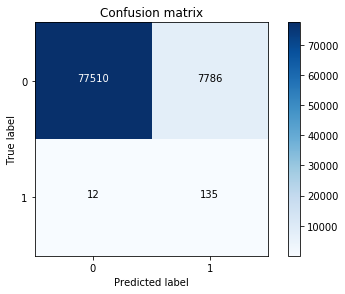

In [12]:
lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(X_train_undersample, y_train_undersample.values.ravel())
y_pred = lr.predict(X_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=class_names,
                      title='Confusion matrix')
plt.show()

### 寻找适用于完整训练集的best_c

In [13]:
best_c = printing_Kfold_scores(X_train, y_train)

-------------------------------------------
C parameter:  0.01
-------------------------------------------

Iteration  1 : recall score =  0.4925373134328358
Iteration  2 : recall score =  0.6027397260273972
Iteration  3 : recall score =  0.6833333333333333
Iteration  4 : recall score =  0.5692307692307692
Iteration  5 : recall score =  0.45

Mean recall score  0.5595682284048672

-------------------------------------------
C parameter:  0.1
-------------------------------------------

Iteration  1 : recall score =  0.5671641791044776
Iteration  2 : recall score =  0.6164383561643836
Iteration  3 : recall score =  0.6833333333333333
Iteration  4 : recall score =  0.5846153846153846
Iteration  5 : recall score =  0.525

Mean recall score  0.5953102506435158

-------------------------------------------
C parameter:  1
-------------------------------------------

Iteration  1 : recall score =  0.5522388059701493
Iteration  2 : recall score =  0.6164383561643836
Iteration  3 : recall score

Recall metric in the testing dataset:  0.6190476190476191


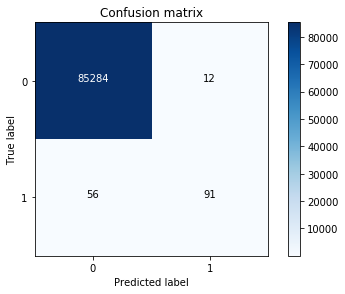

In [14]:
lr = LogisticRegression(C=best_c, penalty = 'l1')
lr.fit(X_train, y_train.values.ravel())
y_pred_undersample = lr.predict(X_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_undersample)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=class_names,
                      title='Confusion matrix')
plt.show()

### 自定义thresholds

Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  0.9863945578231292
Recall metric in the testing dataset:  0.9319727891156463
Recall metric in the testing dataset:  0.8707482993197279
Recall metric in the testing dataset:  0.8299319727891157
Recall metric in the testing dataset:  0.7482993197278912
Recall metric in the testing dataset:  0.5918367346938775


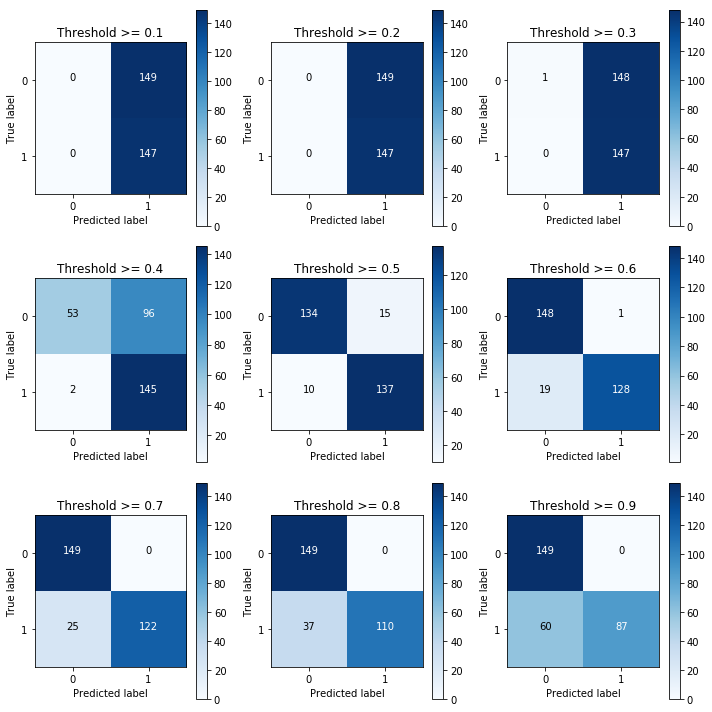

In [15]:
lr = LogisticRegression(C=0.01, penalty = 'l1')
lr.fit(X_train_undersample, y_train_undersample.values.ravel())
y_pred_undersample_proba = lr.predict_proba(X_test_undersample.values)

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

plt.figure(figsize=(10,10))

j = 1
for i in thresholds:
    y_test_predictions_high_recall = y_pred_undersample_proba[:, 1] > i
    
    plt.subplot(3, 3, j)
    j += 1
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test_undersample, y_test_predictions_high_recall)
    np.set_printoptions(precision=2)

    print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

    # Plot non-normalized confusion matrix
    class_names = [0, 1]
    plot_confusion_matrix(cnf_matrix,
                          classes=class_names,
                          title='Threshold >= %s'%i) 